<a href="https://colab.research.google.com/github/tomMEM/Weather_data/blob/main/Weather_data_scraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd drive/My Drive
%cd Weather

/content/drive/My Drive
/content/drive/My Drive/Weather


In [4]:
! ls

Berlin.csv  Weather_data_scraping.ipynb


### 1 Install Meteostat 
 * WEB:https://meteostat.net/en/place/CA-QVT9?t=2021-09-13/2021-09-19
 * Script sample: https://pypi.org/project/meteostat/
 * Developer: https://github.com/sponsors/clampr

In [5]:
#! pip install meteostat 
import sys
!{sys.executable} -m pip install --upgrade meteostat

Berlin   : 52.5170365 13.3888599


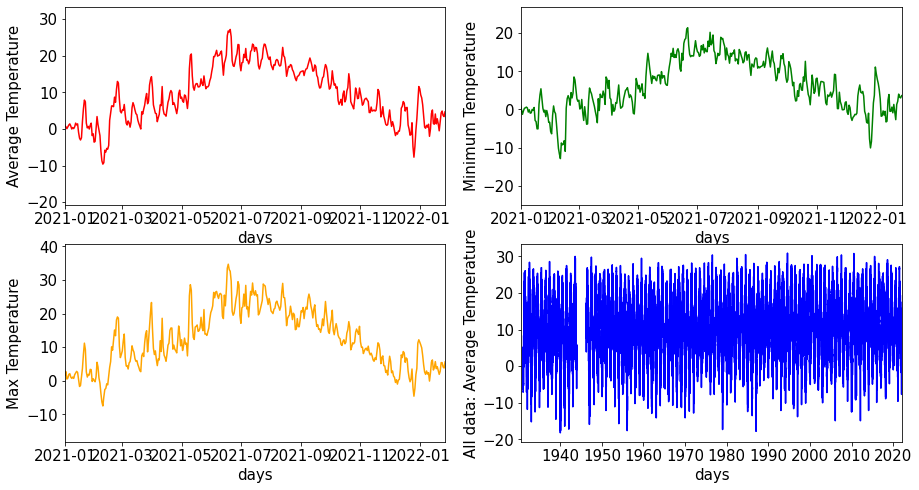

In [35]:
# Import Meteostat library and dependencies
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Daily
from geopy.geocoders import Nominatim

# Set time period 
start = datetime(1930, 9, 15)
#end = datetime(2021, 9, 15)
end = datetime.now()
# e.g. Create Point for Vancouver, BC
#location = Point(49.2497, -123.1193, 70)

# Set location
location_name='Berlin'

# get Latitude and Longitude
geolocator = Nominatim(user_agent='myapplication')
location = geolocator.geocode(location_name)
latitude_value=location.latitude
longitude_value=location.longitude
print (location_name,'  :',latitude_value, longitude_value,)

# TB: Create Point for Berlin, Germany
location = Point(latitude_value, longitude_value, 70)

# Get daily data
data = Daily(location, start, end)
data = data.fetch()

#TB save as csv
data.to_csv(location_name+'.csv')

# create a horizontal plot
def figureplots(rownew, columnew, datanew, colornew, labelnew, dstartTBnew, dnowTBnew):
  #graphs in a figures using subplots
  axs[columnew, rownew].plot(datanew, color=colornew)
  axs[columnew, rownew].set_xlim(dstartTBnew, dnowTBnew)
  axs[columnew, rownew].set_xlabel('days')
  axs[columnew, rownew].set_ylabel(labelnew)
    

#define start and end date
dnowTB = datetime.now()
dstartTB=datetime(2021,1,1)

fig, axs = plt.subplots(2, 2, figsize=(15, 8))
plt.rc('font', size=15)
#figureplots(rownew, columnew, datanew, colornew, labelnew, dstartTB, dnowTB)
figureplots(0, 0, data['tavg'], 'red', 'Average Temperature', dstartTB, dnowTB)
figureplots(1, 0, data['tmin'], 'green', 'Minimum Temperature', dstartTB, dnowTB)
figureplots(0, 1, data['tmax'], 'orange', 'Max Temperature', dstartTB, dnowTB)
figureplots(1, 1, data['tavg'], 'blue', 'All data: Average Temperature', start, dnowTB)
plt.show()



In [4]:
#view of dataframe
data.tail()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2022-01-23,4.4,2.1,5.4,0.7,0.0,296.5,9.6,24.1,1032.2,0.0
2022-01-24,4.9,4.0,5.4,0.0,NaN,277.0,8.4,18.5,1034.5,NaN
2022-01-25,3.7,3.2,4.1,0.2,NaN,277.3,12.1,27.8,1031.8,NaN
2022-01-26,3.4,3.0,3.8,0.1,NaN,269.3,17.1,38.9,1027.5,NaN
2022-01-27,4.7,3.6,5.6,1.6,NaN,258.9,25.3,59.3,1016.4,NaN


# interpolation using spline

In [5]:
from sklearn.datasets import load_boston
from scipy import interpolate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
datacopied=data
datacopied.tail()

range(0, 13373) 13373


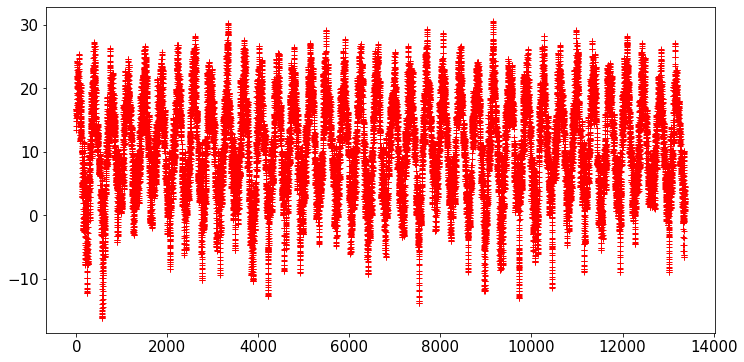

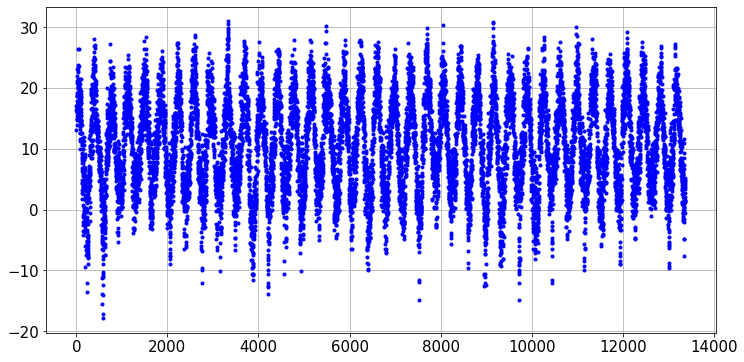

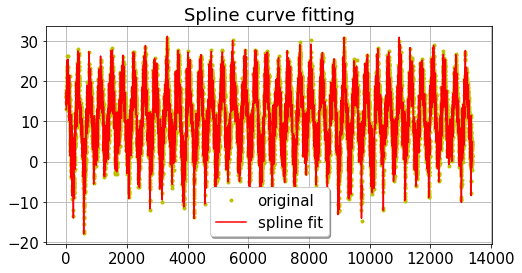

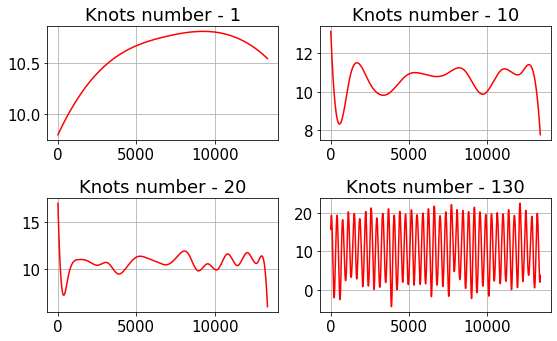

In [56]:
y = datacopied['tavg'][20000:len(datacopied)]

x = range(0, len(y))
print(x,len(y))
mytck,myu=itp.splprep([x,y])
xnew,ynew= itp.splev(np.linspace(0,1,len(y)*2),mytck)
plt.figure(figsize=(12, 6))
plt.plot(xnew,ynew,'+',c="r")

plt.figure(figsize=(12, 6))
plt.plot(x, y, '.', c="b")
plt.grid()
plt.show()


knot_numbers = 10000
x_new = np.linspace(0, 1, knot_numbers+2)[1:-1]
q_knots = np.quantile(x, x_new) 

 
t,c,k = interpolate.splrep(x, y, t=q_knots, s=1)
yfit = interpolate.BSpline(t,c,k)(x)


plt.figure(figsize=(8, 4))
plt.title("Spline curve fitting")
plt.plot(x, y, '.', c="y", label="original")
plt.plot(x, yfit, '-', c="r", label="spline fit")
plt.legend(loc='best', fancybox=True, shadow=True)

plt.grid()
plt.show() 
 
def spline(knots, y):
    x = range(0, len(y))
    x_new = np.linspace(0, 1, knots+2)[1:-1]
    q_knots = np.quantile(x, x_new)
    t, c, k = interpolate.splrep(x, y, t=q_knots, s=3)
    yfit = interpolate.BSpline(t,c, k)(x)
    return yfit


knots = [1, 10, 20, 130]
i = 0

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 5)) 

 

for row in range(2):
    for col in range(2):
        #ax[row][col].plot(x, y, '.',c="g", markersize=2)
        yfit = spline(knots[i], y)
        ax[row][col].plot(x, yfit, 'r')
        ax[row][col].set_title("Knots number - "+str(knots[i]))
        ax[row][col].grid()       
        i=i+1
        
plt.tight_layout()        
plt.show() 

# just some additonal testings and collections

In [ ]:
from scipy import interpolate as itp
y = datacopied['tavg'][20000:len(datacopied)]

x = range(0, len(y))
print(x,len(y))
mytck,myu=itp.splprep([x,y])
xnew,ynew= itp.splev(np.linspace(0,1,15000),mytck)
plt.plot(xnew,ynew)

In [ ]:
# Might be not required
from pandas_datareader import data as pdr
import pandas as pd
from pandas import *
from pandas import ExcelWriter
import pandas as pd
import datetime
import time

import os.path
from os import path
import csv

In [ ]:
# might be not required
import sys
!{sys.executable} -m pip install --upgrade pandas==1.1.0 --no-cache-dir
!{sys.executable} -m pip install --upgrade urllib3==1.25.8 --no-cache-dir
!{sys.executable} -m pip install pandas-datareader --no-cache-dir